## Homework 1
http://wiki.quantsoftware.org/index.php?title=CompInvestI_Homework_1<br>
http://wiki.quantsoftware.org/index.php?title=QSTK_Tutorial_1

In [1]:
import pandas_datareader.data as web
from lib import DataAccess as da
from lib import qsdateutil as du
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

__Inputs:__<br>
Start date (e.g. '01/01/2010')<br> 
End date<br>
Symbols for for equities (e.g., GOOG, AAPL, GLD, XOM)<br>
Allocations to the equities at the beginning of the simulation (e.g., 0.2, 0.3, 0.4, 0.1)<br>
__Return:__<br>
Standard deviation of daily returns of the total portfolio<br>
Average daily return of the total portfolio<br>
Sharpe ratio (Always assume you have 252 trading days in an year. And risk free rate = 0) of the total portfolio<br>
Cumulative return of the total portfolio<br>

In [2]:
c_dataobj = da.DataAccess('Yahoo')

In [3]:
def simulate(startdate,enddate,symbols,allocations):
    global c_dataobj
    
    #date
    dt_timeofday = dt.timedelta(hours=16)
    timestamps = du.getNYSEdays(startdate, enddate, dt_timeofday)
    
    #data
    keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
    ldf_data = c_dataobj.get_data(timestamps, symbols, keys)
    d_data = dict(zip(keys, ldf_data))
    
    #normalize
    df = d_data["close"]/d_data["close"].iloc[0]
    #allocations
    for a,s in zip(allocations, symbols):
        df[s] = df[s]*a
    
    #new columns
    df['comu_ret'] = [sum(row) for _,row in df.iterrows()]
    df['daily_ret'] = [0.0]+[df['comu_ret'][i+1]/df['comu_ret'][i]-1 for i in range(len(df)-1)]
    
    #the returns 
    vol = np.std(df['daily_ret'])
    daily_ret_avg = df['daily_ret'].mean()
    sharpe = np.sqrt(252)*daily_ret_avg/vol
    cum_ret = df['comu_ret'][-1]-1

    return vol, daily_ret_avg, sharpe, cum_ret

#### Exemplo 1

In [4]:
startdate = dt.datetime(2011, 1, 1)
enddate = dt.datetime(2011, 12, 31)
symbols = ['AAPL', 'GLD', 'GOOG', 'XOM']
allocations = [0.4, 0.4, 0.0, 0.2]
vol,daily_ret,sharpe,cum_ret = simulate(startdate,enddate,symbols,allocations)
vol,daily_ret,sharpe,cum_ret 

(0.010146706765352471,
 0.0006572611020014274,
 1.0282840309941454,
 0.16487261964506139)

#### Exemplo 2

In [5]:
startdate = dt.datetime(2010, 1, 1)
enddate = dt.datetime(2010, 12, 31)
symbols = ['AXP', 'HPQ', 'IBM', 'HNZ']
allocations = [0.0, 0.0, 0.0, 1.0]
vol,daily_ret,sharpe,cum_ret = simulate(startdate,enddate,symbols,allocations)
vol,daily_ret,sharpe,cum_ret 

(0.0092429925593663989,
 0.00075628558559302621,
 1.2988933400758884,
 0.19605835679549521)

#### Portfolio Optimizer:
Best portfolio = Highest Sharpe Ratio.

In [6]:
high_sharpe = 0
high_allocations = 0
for i1 in range(11):
    for i2 in range(11):
        for i3 in range(11):
            for i4 in range(11):
                allocations = np.array([i1,i2,i3,i4],dtype = float)/10
                if sum(allocations) != 1.0:
                    continue
                _,_,sharpe,_ = simulate(startdate,enddate,symbols,allocations)
                if sharpe > high_sharpe:
                    high_sharpe = sharpe
                    high_allocations = allocations
high_allocations,high_sharpe

(array([ 0.,  0.,  0.,  1.]), 1.2988933400758884)

#### Plot:
data:

In [7]:
#date
dt_timeofday = dt.timedelta(hours=16)
timestamps = du.getNYSEdays(startdate, enddate, dt_timeofday)
#data
keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']
ldf_data = c_dataobj.get_data(timestamps, symbols, keys)
d_data = dict(zip(keys, ldf_data))
#closes and daily return
closes = d_data['close'].values
dates = d_data['close'].index
daily_ret = closes[1:]/closes[:-1]-1

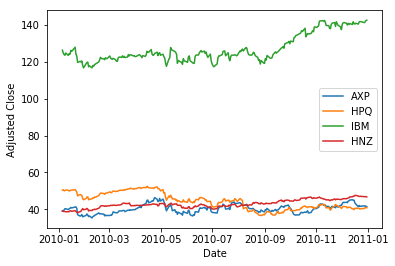

In [8]:
plt.plot(dates,closes)
plt.legend(symbols)
plt.ylabel('Adjusted Close')
plt.xlabel('Date')
plt.show()

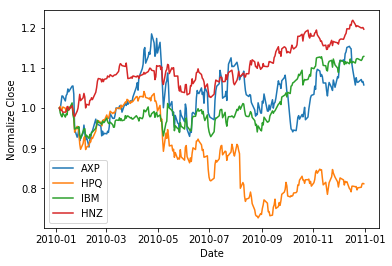

In [9]:
plt.plot(dates,closes/closes[0])
plt.legend(symbols)
plt.ylabel('Normalize Close')
plt.xlabel('Date')
plt.show()

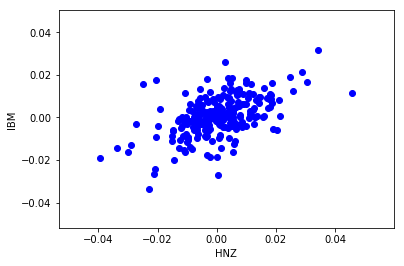

In [10]:
plt.scatter(daily_ret[:,2], daily_ret[:,3], c='blue')
plt.ylabel(symbols[2])
plt.xlabel(symbols[3])
plt.show()

## Extra challenges
Find the best allocations using optimization algorithms.

In [11]:
from scipy.optimize import minimize

e.g. <br>
if x = [1,2] means:<br>
y[1] = 1y[0] <br>
y[2] = 2y[0]<br>
sum(y) = 1<br>
y[0],y[1],y[2]>0<br>
   then return [0.25,0.25,0.5]

In [12]:
def relationTOmax1(x):
    x = np.array([1]+list(abs(x)),dtype = float)
    return x/x.sum()

Function to minimize:

In [13]:
def f(x,startdate,enddate,symbols):
    allocations = relationTOmax1(x)
    _,_,sharpe,_ = simulate(startdate,enddate,symbols,allocations)
    return 1/sharpe

Optimize:

In [14]:
%%time
startdate = dt.datetime(2011, 1, 1)
enddate = dt.datetime(2011, 12, 31)
symbols = ['AAPL', 'GLD', 'GOOG', 'XOM']
args = (startdate,enddate,symbols)

x0 = [1,1,1]
res = minimize(f, x0, args = args, method='Nelder-Mead',
            options={'maxiter': 1000, 'disp': True})

Optimization terminated successfully.
         Current function value: 1.001676
         Iterations: 47
         Function evaluations: 94
CPU times: user 2.55 s, sys: 275 µs, total: 2.55 s
Wall time: 2.57 s


Result:

In [15]:
best_allocations = np.around(relationTOmax1(res.x),decimals=3)
best_allocations

array([ 0.266,  0.427,  0.   ,  0.306])